# Convolutional Neural Network for Image Classification

This notebook contains a Convolutional Neural Network (CNN) implemented in Keras for classifying images. The CNN is trained on a dataset of chest X-ray images, with the aim of detecting whether or not the images contain signs of pneumonia.

The notebook is structured as follows:

- **Importing Libraries**: Necessary libraries and modules are imported.
- **Data Preparation**: The image data is loaded and preprocessed for training.
- **Model Building**: The CNN model is defined and compiled.
- **Model Training**: The model is trained on the training data and validated on the validation data.
- **Model Evaluation**: The model's performance is evaluated on the test data.
- **Model Saving**: The trained model is saved for future use.

Let's get started!

## Importing Libraries

First, we import all the necessary libraries and modules for our CNN. This includes TensorFlow and Keras for building the CNN, as well as os and numpy for data handling.

In [359]:
import os
import itertools
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras import metrics
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SeparableConv2D,BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import datetime
import tensorflow as tf

In [360]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [361]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


## Data Preparation

Next, we set up the paths to the directories containing our training, validation, and test data. We also define some parameters for our images and training process, such as the image dimensions, the batch size, and the number of epochs.

In [362]:
# Set up data directories
normal_data_dir = "chest_Xray\\train\\NORMAL"
pneumonia_data_dir = "chest_Xray\\train\\PNEUMONIA"
train_data_dir = "chest_Xray\\train"
validation_data_dir = "chest_Xray\\val"
test_data_dir = "chest_Xray\\test"

# Define image parameters
img_height = 336
img_width = 336
num_channels = 1  # Set to 1 for grayscale images

# Define training parameters
batch_size = 64
num_epochs = 30
learning_rate = 0.0005
es_patience = 3
reducelrp_factor = 0.3

We then set up our image data generators. These will automatically load our images from the directories, apply some data augmentation techniques to the training images to increase the diversity of our training data, and rescale the pixel values from [0, 255] to [0, 1].

## Model Building

Next, we define our CNN model. This is a sequential model with several convolutional layers, each followed by a max pooling layer. We also include dropout layers to reduce overfitting, and a final dense layer for binary classification.

In [363]:
# Define the model
model = Sequential([
    Conv2D(8, (3, 3), activation=LeakyReLU(), input_shape=(img_height, img_width, num_channels), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(16, (3, 3), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(16, (3, 3), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(8, (5, 5), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),

    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


After defining the model, we compile it with the Adam optimizer and binary crossentropy loss function, since this is a binary classification problem. We also specify that we want to track accuracy as a metric during training.

In [364]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy', 
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)

model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_234 (Conv2D)         (None, 336, 336, 8)       80        
                                                                 
 batch_normalization_222 (Ba  (None, 336, 336, 8)      32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_173 (MaxPooli  (None, 168, 168, 8)      0         
 ng2D)                                                           
                                                                 
 conv2d_235 (Conv2D)         (None, 168, 168, 16)      1168      
                                                                 
 batch_normalization_223 (Ba  (None, 168, 168, 16)     64        
 tchNormalization)                                               
                                                     

TensorBoard logs

In [365]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

We also set up some callbacks for our training process. The `EarlyStopping` callback will stop the training if the validation loss does not improve for a certain number of epochs, and the `ReduceLROnPlateau` callback will reduce the learning rate when the validation loss stops improving, to allow for finer tuning.

In [366]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=es_patience, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=reducelrp_factor, patience=3, verbose=1, min_lr=5e-6)

## Model Training

Now we're ready to train our model. We first set up our data generators to load the images, and then we call the `fit` method on our model to start the training.

In [367]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# No rotation as X-Rays are not usually rotated
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [368]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    seed=42,
    shuffle=False
)

Found 5168 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [369]:
# show class labels for reference
print(train_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [370]:
# num_normal = len(os.listdir(normal_data_dir))
# num_pneumonia = len(os.listdir(pneumonia_data_dir))

# class_weight = {0: num_pneumonia / num_normal, 1: 1.}

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=num_epochs,
    callbacks=[reduce_lr_on_plateau, tensorboard_callback, tboard_callback] 
)

Epoch 1/20
81/81 [==============================] - 32s 389ms/step - loss: 0.3872 - accuracy: 0.9048 - precision: 0.9354 - recall: 0.9369 - auc: 0.9467 - val_loss: 1.8343 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8008 - lr: 5.0000e-04
Epoch 2/20
81/81 [==============================] - 31s 377ms/step - loss: 0.2752 - accuracy: 0.9396 - precision: 0.9607 - recall: 0.9582 - auc: 0.9780 - val_loss: 2.1239 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.7910 - lr: 5.0000e-04
Epoch 3/20
81/81 [==============================] - 31s 385ms/step - loss: 0.2348 - accuracy: 0.9555 - precision: 0.9716 - recall: 0.9686 - auc: 0.9850 - val_loss: 1.8300 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.9463 - lr: 5.0000e-04
Epoch 4/20
81/81 [==============================] - 31s 385ms/step - loss: 0.2294 - accuracy: 0.9509 - precision: 0.9690 - recall: 0.9649 - auc: 0.9858 - val_loss: 1.3193 - val_a

In [ ]:
%tensorboard --logdir logs/fit


## Model Evaluation

After training, we evaluate our model on the test data to see how well it performs.

In [371]:
# Evaluate the model
# Evaluate the model
scores = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test loss: {scores[0]:.4f}")
print(f"Test accuracy: {scores[1]:.4f}")
print(f"Test Precision: {scores[2]:.4f}")
print(f"Test Recall: {scores[3]:.4f}")
print(f"Test F1-score: {scores[4]:.4f}")


10/10 [==============================] - 2s 166ms/step - loss: 0.4423 - accuracy: 0.8894 - precision: 0.9373 - recall: 0.8821 - auc: 0.9488
Test loss: 0.4423
Test accuracy: 0.8894
Test Precision: 0.9373
Test Recall: 0.8821
Test F1-score: 0.9488


## Model Saving

Finally, we save our trained model for future use. In a real-world scenario, you would likely want to use this model to make predictions on new data.

In [385]:
# Save the model
model.save("chest_xray_model.h5")
print("Model saved as chest_xray_model.h5")

Model saved as chest_xray_model.h5


INFERENCE

In [403]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image


In [398]:
normal_folder = "chest_Xray\\test\\NORMAL"
pneumonia_folder = "chest_Xray\\test\\PNEUMONIA"
models_folder = r"models"
img_height = 336
img_width = 336

model_results = []

In [401]:
def preprocess_image(image_path, img_height, img_width):
    img = Image.open(image_path).convert('L')  # 'L' stands for grayscale
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0  # normalize pixel values
    img_array = np.expand_dims(img_array, axis=-1)  # expand dimensions for batch input
    img_array = np.expand_dims(img_array, axis=0)  # expand dimensions for batch input
    return img_array
loaded_model = ''
for model_name in os.listdir(models_folder):
        model_path = os.path.join(models_folder, model_name)
        if not os.path.isfile(model_path):
            continue

        loaded_model = load_model(model_path)

        def is_prediction_correct(image_path, true_class):
            preprocessed_image = preprocess_image(image_path, img_height, img_width)
            prediction = loaded_model.predict(preprocessed_image)
            predicted_class = "pneumonia" if prediction[0][0] > 0.5 else "normal"
            return predicted_class == true_class

        results = {
            "normal": {"correct": 0, "total": 0},
            "pneumonia": {"correct": 0, "total": 0},
        }

        for folder, true_class in [(normal_folder, "normal"), (pneumonia_folder, "pneumonia")]:
            for image_name in os.listdir(folder):
                image_path = os.path.join(folder, image_name)
                results[true_class]["total"] += 1
                if is_prediction_correct(image_path, true_class):
                    results[true_class]["correct"] += 1

        total_correct = results["normal"]["correct"] + results["pneumonia"]["correct"]
        total_images = results["normal"]["total"] + results["pneumonia"]["total"]
        normal_correct_pct = (results["normal"]["correct"] / results["normal"]["total"]) * 100
        pneumonia_correct_pct = (results["pneumonia"]["correct"] / results["pneumonia"]["total"]) * 100
        overall_correct_pct = (total_correct / total_images) * 100

        model_results.append({
            "name": model_name,
            "results": results,
            "total_correct": total_correct,
            "normal_correct_pct": normal_correct_pct,
            "pneumonia_correct_pct": pneumonia_correct_pct,
            "overall_correct_pct": overall_correct_pct
        })

13/13 [==============================] - 0s 5ms/step


In [402]:
sorted_by_total_correct = sorted(model_results, key=lambda x: x["total_correct"], reverse=True)
sorted_by_normal_correct_pct = sorted(model_results, key=lambda x: x["normal_correct_pct"], reverse=True)
sorted_by_pneumonia_correct_pct = sorted(model_results, key=lambda x: x["pneumonia_correct_pct"], reverse=True)

print("Sorted by total correct:")
for result in sorted_by_total_correct:
    print(result["name"], result["total_correct"], result["overall_correct_pct"])

print("\nSorted by normal correct %:")
for result in sorted_by_normal_correct_pct:
    print(result["name"], result["normal_correct_pct"])

print("\nSorted by pneumonia correct %:")
for result in sorted_by_pneumonia_correct_pct:
    print(result["name"], result["pneumonia_correct_pct"])
    

Sorted by total correct:

Sorted by normal correct %:

Sorted by pneumonia correct %:


ROC CURVE

10/10 [==============================] - 2s 159ms/step


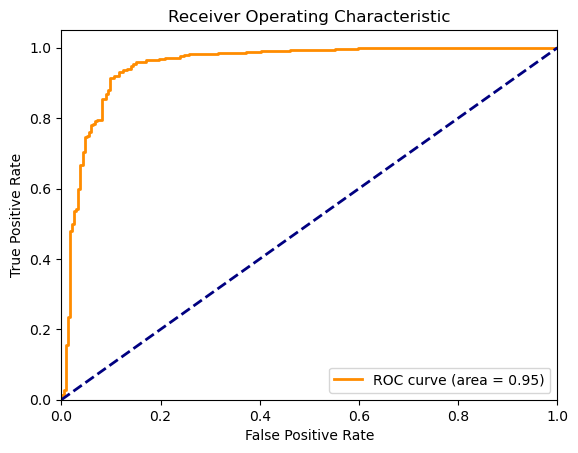

In [377]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'test_generator' contains the test data
y_test = test_generator.classes
# predict probabilities for test set
y_pred = model.predict(test_generator, verbose=1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


CONFUSION MATRIX


In [380]:
print(model.predict(test_generator, steps=len(test_generator)))

10/10 [==============================] - 2s 155ms/step
[[3.44836099e-06]
 [2.08257261e-04]
 [4.13295274e-05]
 [2.78945110e-04]
 [2.60504985e-05]
 [9.10785093e-05]
 [1.14552349e-05]
 [2.12291161e-05]
 [7.50156687e-06]
 [1.77810725e-04]
 [2.32520574e-06]
 [7.19411240e-04]
 [1.43222383e-06]
 [1.49661164e-05]
 [1.60258554e-03]
 [5.85267589e-05]
 [8.66846800e-01]
 [3.47280184e-05]
 [8.65876704e-09]
 [1.55002010e-06]
 [7.51632906e-04]
 [1.13811784e-05]
 [7.75593985e-03]
 [2.80813929e-05]
 [1.14255010e-04]
 [2.90874887e-04]
 [3.38419690e-04]
 [8.25039479e-06]
 [2.74643844e-05]
 [2.23750409e-04]
 [4.19851904e-06]
 [9.87237203e-04]
 [3.14243189e-05]
 [2.20966399e-06]
 [1.54054123e-05]
 [5.87045133e-06]
 [1.88282567e-09]
 [4.56237012e-06]
 [3.04438181e-05]
 [1.46021543e-03]
 [2.39333589e-04]
 [3.48957133e-06]
 [2.57896700e-05]
 [7.11570692e-07]
 [8.89245700e-03]
 [2.96536810e-03]
 [1.98615920e-02]
 [1.56079810e-02]
 [4.47384722e-04]
 [1.14731891e-04]
 [5.97013532e-05]
 [4.61953205e-05]
 [5.13683

10/10 [==============================] - 2s 158ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

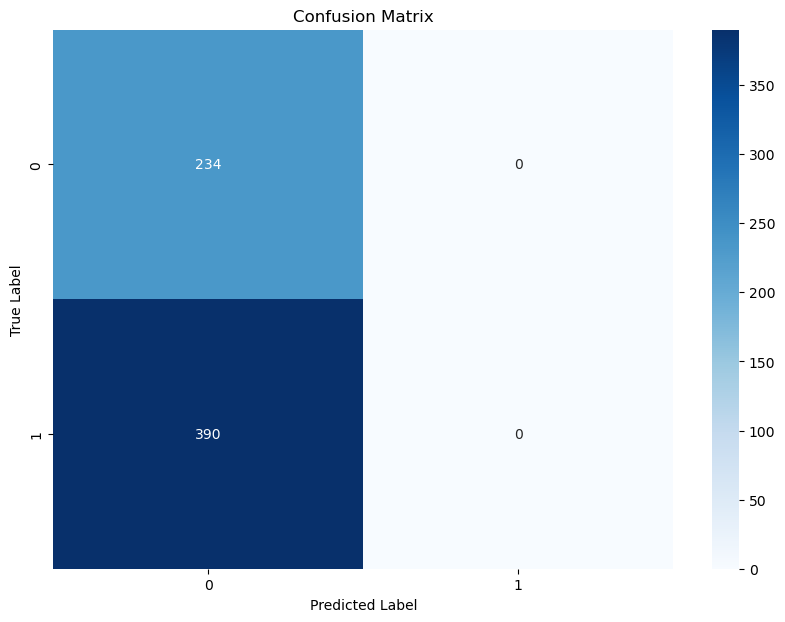

In [393]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(model, test_generator):
    # Get the true labels
    true_labels = test_generator.classes
    
    # Predict probabilities of each class for the images in the test set
    predictions = loaded_model.predict(test_generator, steps=len(test_generator))
    
    # Convert the probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    print(predicted_labels)
    # Compute the confusion matrix
    matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Create a heatmap of the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(model, test_generator)


In [384]:
# tf.math.confusion_matrix(
#     labels,
#     predictions,
#     num_classes=None,
#     weights=None,
#     dtype=tf.dtypes.int32,
#     name=None
# )

tf.math.confusion_matrix(
    test_generator.classes,
    model.predict(test_generator, steps=len(test_generator)),
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

10/10 [==============================] - 2s 156ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[234,   0],
       [390,   0]])>